# Propaganda Detection Problem

## Problem statement

**Given data sets:** https://www.kaggle.com/datasets/mattimansha/verified-posts-fact-checking-online-content - Verified Posts: Fact-Checking Online Content on Kaggle
https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k - Misinformation & Fake News text dataset 79k on Kaggle
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset - Fake and real news dataset on Kaggle
https://www.kaggle.com/datasets/bohdanmynzar/twitter-propaganda-classification - Twitter Ru Propaganda Classification on Kaggle

**Objective:** To develop a classifier which will detect if a given text has a significant amount of propaganda.

**Methodology used:**

https://en.wiktionary.org/wiki/Wiktionary:Main_Page - largest English dictionary

https://www.frontiersin.org/articles/10.3389/fpsyg.2016.01116/full - How Many Words Do We Know? Practical Estimates of Vocabulary Size Dependent on Word Definition, the Degree of Language Input and the Participants Age by Marc Brysbaert, Michaël Stevens, Paweł Mandera and Emmanuel Keuleers

https://nlp.stanford.edu/projects/glove/ - GloVe: Global Vectors for Word Representation by Jeffrey Pennington, Richard Socher, Christopher D. Manning

https://fasttext.cc/docs/en/english-vectors.html - English word vectors by Facebook

https://catalog.ldc.upenn.edu/LDC2011T07 -
English Gigaword Fifth Edition by Robert Parker, David Graff, Junbo Kong, Ke Chen, Kazuaki Maeda

https://ebiquity.umbc.edu/resource/html/id/351/UMBC-webbase-corpus - UMBC webbase corpus by Lushan Han

https://code.google.com/archive/p/word2vec/ - word2vec by Google





## Importing libraries

In [ ]:
!pip install platform
print(platform.uname().system)
print(platform.architecture())
!python3 --version
!cat /etc/*release

In [226]:
from google.colab import drive
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from typing import List
import numpy as np
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from functools import reduce
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
import string
import pickle
import shutil

folder_path = '/content/drive/My Drive/Colab Work/Saved Results/'

## Loading data

In [173]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading "Misinformation & Fake News text dataset 79k" dataset

In [174]:
X_fake_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/DataSet_Misinfo_FAKE.csv')
X_true_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/DataSet_Misinfo_TRUE.csv')
X_propaganda_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/EXTRA_RussianPropagandaSubset.csv')

In [ ]:
X_fake_m.info()

In [ ]:
X_true_m.info()

In [ ]:
X_propaganda_m.info()

### Loading "Verified Posts: Fact-Checking Online Content" dataset

In [175]:
df_v = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/Politifact_data.csv')

In [ ]:
df_v.info()

### Loading "Fake and real news dataset" dataset

In [176]:
X_fake_f = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/Fake.csv')
X_true_f = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/True.csv')

In [ ]:
X_fake_f.info()

In [ ]:
X_true_f.info()

### Loading "Twitter Ru Propaganda Classification" dataset

In [177]:
df_t = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/twitter_dataset.csv')

In [ ]:
df_t.info()

## Exploring, visualising and pre-procesing data

### "Misinformation & Fake News text dataset 79k" dataset

In [178]:
X_m_fp = pd.concat([X_fake_m, X_propaganda_m], ignore_index=True)
X_m_fp['propaganda'] = 1
X_true_m['propaganda'] = 0
df_m = pd.concat([X_m_fp, X_true_m], ignore_index=True)
df_m = df_m.drop(columns=['Unnamed: 0'])
df_m = df_m.sample(frac=1).reset_index(drop=True)

In [179]:
column_names_m = [x for x in df_m.columns]
n_columns_m = len(df_m.columns)
n_rows_m = len(df_m)
print('There are {} columns and {} rows in the dataframe.'.format(n_columns_m, n_rows_m))

n_missing_m = df_m.isnull().sum().sum()
print(f'There are {n_missing_m} rows in total with missing values.')
df_m = df_m.dropna()

df_m

There are 2 columns and 85986 rows in the dataframe.
There are 32 rows in total with missing values.


,text,propaganda
0,China called on U.S. officials on Tuesday not ...,0
1,The standoff over North Korea could lead to n...,0
2,New York State Attorney Eric Schneiderman on T...,0
3,Prince Charles led the annual ceremony to hono...,0
4,Video recording where a Russian intelligence o...,1
...,...,...
85981,Malaysian Prime Minister Najib Razak called on...,0
85982,"Buffalo Bills coach Rex Ryan has one job, to i...",1
85983,The US Senate demanded to conduct a military o...,1
85984,Jesse Watters: GOP can t drain the swamp when ...,1


### "Verified Posts: Fact-Checking Online Content" dataset

In [180]:
column_names_v = [x for x in df_v.columns]
n_columns_v = len(df_v.columns)
n_rows_v = len(df_v)
print('There are {} columns and {} rows in the dataframe.'.format(n_columns_v, n_rows_v))

n_missing_v = df_v.isnull().sum().sum()
print(f'There are {n_missing_v} rows in total with missing values.')

There are 5 columns and 22020 rows in the dataframe.
There are 0 rows in total with missing values.


In [181]:
df_v = df_v.drop(columns=['Title', 'StartDate', 'Link'])
df_v.Status.unique()

array(['false', 'pants-fire', 'half-true', 'mostly-true', 'full-flop',
       'barely-true', 'true', 'half-flip', 'no-flip'], dtype=object)

In [182]:
df_v = df_v.rename(columns={"Post": "text", "Status": "propaganda"})
df_v = df_v[df_v.propaganda.isin(['no-flip', 'half-flip', 'full-flop']) == False]
df_v = df_v.replace(['half-true', 'barely-true', 'false', 'pants-fire'], 1)
df_v = df_v.replace(['true', 'mostly-true'], 0)
df_v = df_v.sample(frac=1).reset_index(drop=True)
df_v

,text,propaganda
0,"""Nancy Pelosi vows Democrats will raise taxes ...",1
1,"""Nationally, the unemployment rate for veteran...",1
2,"""The Sun is out of place, the Moon is out of p...",1
3,Terrorism and terrorist attacks in the United ...,1
4,"Pfizer is ""literally using the force of govern...",1
...,...,...
21730,"""215 members of Congress just voted to let you...",0
21731,"Says he ""stood up to his own party by voting a...",1
21732,"""One hundred and ninety-four countries signed ...",0
21733,"Says the Coronavirus Aid, Relief, and Economic...",1


### "Fake and real news dataset" dataset

In [183]:
X_true_f['propaganda'] = 0
X_fake_f['propaganda'] = 1

df_f = pd.concat([X_true_f, X_fake_f], ignore_index=True)

column_names_f = [x for x in df_f.columns]
n_columns_f = len(df_f.columns)
n_rows_f = len(df_f)
print('There are {} columns and {} rows in the dataframe.'.format(n_columns_f, n_rows_f))

n_missing_f = df_f.isnull().sum().sum()
print(f'There are {n_missing_f} rows in total with missing values.')

There are 5 columns and 44898 rows in the dataframe.
There are 0 rows in total with missing values.


In [184]:
df_f = df_f.drop(columns=['title', 'subject', 'date'])

df_f = df_f.sample(frac=1).reset_index(drop=True)

df_f

,text,propaganda
0,CAIRO (Reuters) - U.S. President Donald Trump ...,0
1,(Reuters) - A committee of Kansas lawmakers wi...,0
2,(Reuters) - President-elect Donald Trump said ...,0
3,Patrick Henningsen 21st Century WireSo far as ...,1
4,"For nigh on two years now, wise people have be...",1
...,...,...
44893,I think it s all senseless. All senseless. ...,1
44894,WASHINGTON (Reuters) - U.S. President Donald T...,0
44895,"It s 2017, and lynchings of black people still...",1
44896,HONOLULU (Reuters) - A federal judge in Hawaii...,0


### "Twitter Ru Propaganda Classification" dataset

In [185]:
column_names_t = [x for x in df_t.columns]
n_columns_t = len(df_t.columns)
n_rows_t = len(df_t)
print('There are {} columns and {} rows in the dataframe.'.format(n_columns_t, n_rows_t))

n_missing_t = df_t.isnull().sum().sum()
print(f'There are {n_missing_t} rows in total with missing values.')

There are 5 columns and 12990 rows in the dataframe.
There are 0 rows in total with missing values.


In [186]:
df_t = df_t.drop(columns=['Unnamed: 0', 'id', 'created_at'])

In [187]:
df_t = df_t.rename(columns={'is_propaganda': 'propaganda'})
df_t = df_t.replace(['True'], 1)
df_t = df_t.replace(['False'], 0)
df_t = df_t.sample(frac=1).reset_index(drop=True)
df_t

,text,propaganda
0,RT @BloombergLive: Russia’s invasion of Ukrain...,False
1,German Chancellor Olaf Scholz and French Presi...,False
2,RT @RF_OSCE: #Lukashevich: Pentagon’s activit...,True
3,"Garrett Ziegler, a former staff member of the ...",True
4,China warns US that a `dangerous situation' is...,False
...,...,...
12985,RT @RussianEmbassy: ❓ A curious move on behalf...,True
12986,"⚡️ Macron responds to massacre in Bucha, urges...",False
12987,RT @RusEmbDK: ❗️1946 Notes from #DK and #RU si...,True
12988,Here's the latest updates on Russia's invasion...,False


### Merging all datasets

In [188]:
df = pd.concat([df_m, df_v, df_f, df_t], ignore_index = True)
df = df.sample(frac=1).reset_index(drop = True)

### Adding additional information

In [189]:
add_info = {'text': 'War Is Peace. Freedom Is Slavery. Ignorance Is Strength.', 'propaganda': 1}

df.loc[len(df)] = add_info

In [190]:
df

,text,propaganda
0,Says Oregon’s high minimum wage is the reason ...,1
1,"After a yearslong wait, compounded by addition...",0
2,The move would make it easier for the Trump ad...,0
3,The Democrats and their allies in the media wo...,1
4,The Republican Election Commissioner of Jeffer...,1
...,...,...
165573,New York City led this week’s report from immi...,0
165574,Ohio’s lost more jobs in March than any other ...,0
165575,When former FBI director James Comey refused t...,1
165576,(Reuters) - The U.S. House Committee on Natura...,0


In [192]:
# Save
save_results = open(folder_path + 'df.pickle', 'wb')
pickle.dump(df, save_results)
save_results.close()

# Load
# load_results = open(folder_path + 'file_name.pickle', 'rb')
# name = pickle.load(load_results)


### Data representation

In [ ]:
df['word_count'] = [len(w.split()) for w in df['text']]
sns.histplot(df['word_count'], bins = 10)

In [ ]:
from wordcloud import WordCloud

words = ''

for word in df['text']:
  words = words + word

wordcloud = WordCloud(max_font_size = 50, max_words = 100,
                      background_color = 'white').generate(words)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# propagnda and non-propaganda statements

from wordcloud import WordCloud

words = ''

for word in df[df['propaganda'] == 1]:
  words = words + word

wordcloud = WordCloud(max_font_size = 50, max_words = 100,
                      background_color = 'white').generate(words)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
non_propaganda_words = df[df['propaganda'] == 0]
pos = " ".join(text for text in non_propaganda_words.text)
wordcloud2 = WordCloud(stopwords = stopwords).generate(pos)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Propaganda vs non-Porpaganda amount

ax = df.pivot('propaganda').plot.bar(figsize=(10,10))

In [ ]:
max([len(w.split()) for w in df['text']])

In [ ]:
text_lst = df['text'].tolist()
def average_length (text_lst):
  words = 0
  for c in text_lst:
    words = words + len(c.split())
  average_length = words/len(df)
  return average_length

print('The average length of a text is: ', average_length(text_lst))

## Data cleaning

### Batching

In [193]:
def batching (data, batch_size, num_batches):

  bat_data = []

  for b in range(num_batches):
    start = b * batch_size
    end = (b + 1) * batch_size
    batch = df[start:end]
    bat_data.append(batch)

  if len(df) % batch_size != 0:
    start = num_batches * batch_size
    end = len(df)
    batch = df[start:end]
    bat_data.append(batch)

    return bat_data

In [194]:
batch_size = 50000
num_batches = len(df) // batch_size

batched_data = batching(df['text'], batch_size, num_batches)
df = pd.concat(batched_data)

### Special characters

In [195]:
def special_characters(data):

  data_b_sc = re.sub("@\S+", "", data)

  data_b_sc = re.sub("https?:\/\/.*[\r\n]*", "", data)

  data_b_sc = re.sub("#", "", data)

  punctuation = set(string.punctuation)
  data_b_sc = "".join([character for character in data
                      if character not in punctuation])

  return data_b_sc

In [196]:
df['text'] = df['text'].apply(special_characters)

### ASCII format

In [197]:
def ascii_format (data):

  data_b_sc_af = data.encode(encoding="ascii", errors="ignore")
  data_b_sc_af = data_b_sc_af.decode()
  data_b_sc_af = " ".join([character for character in data_b_sc_af.split()])

  return data_b_sc_af

In [198]:
df['text'] = df['text'].apply(ascii_format)

### Stopwords

In [199]:
nltk.download ("stopwords")
stopwords = set(stopwords.words ("english"))
stopwords_dict = Counter (stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
def stop_words (word):

  data_b_sc_af_sw = word.split()
  data_b_sc_af_sw = [w for w in data_b_sc_af_sw if not w in stopwords_dict]
  data_b_sc_af_sw = ' '.join(data_b_sc_af_sw)

  return data_b_sc_af_sw

In [201]:
df['text'] = df['text'].apply(stop_words)

### Lower case

In [202]:
def lower_case (text):

  data_b_sc_af_sw_lc = []

  for t in text:

    t = t.lower()
    data_b_sc_af_sw_lc.append(t)

  return data_b_sc_af_sw_lc

In [203]:
df['text'] = lower_case (df['text'])

### Removing white space

In [204]:
df['text'] = df['text'].str.strip()

### Chopping text

In [205]:
max_length = 512

def chopping_text(text):

    data_b_sc_af_sw_lc_ct = []
    part_text = []

    if len(text.split()) // 343 > 0:
        n = len(text.split()) // 343
    else:
        n = 1

    for w in range(n):

        if w == 0:
            part_text = text.split()[:max_length]
            data_b_sc_af_sw_lc_ct.append(" ".join(part_text))
        else:
            part_text = text.split()[w*343:w*343 + max_length]
            data_b_sc_af_sw_lc_ct.append(" ".join(part_text))

    return data_b_sc_af_sw_lc_ct

In [206]:
df['text'] = df['text'].apply(chopping_text)

### Augumentation

In [207]:
def augumentation(data):

    index = []
    text = []
    propaganda = []

    for ind, row in data.iterrows():

      for i in row['text']:

        index.append(ind)
        text.append(i)
        propaganda.append(row['propaganda'])

    data_b_sc_af_sw_lc_ct_a = pd.DataFrame ({'index': index, 'text': text, 'propaganda': propaganda})

    return data_b_sc_af_sw_lc_ct_a

In [208]:
df = augumentation(df)

### Scaling

#### Max devision

Best scaler for results

In [209]:
df ['index'] = df ['index'] / max(df ['index'])

In [210]:
df

,index,text,propaganda
0,0.000000,says oregons high minimum wage reason 2011 ore...,1
1,0.000006,after yearslong wait compounded additional del...,0
2,0.000012,the move would make easier trump administratio...,0
3,0.000018,the democrats allies media would like believe ...,1
4,0.000024,the republican election commissioner jefferson...,1
...,...,...,...
179341,0.999976,new york city led weeks report immigration off...,0
179342,0.999982,ohios lost jobs march state nation,0
179343,0.999988,when former fbi director james comey refused t...,1
179344,0.999994,reuters the us house committee natural resourc...,0


#### StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

df ['index'] = StandardScaler().fit_transform(df['index'].values.reshape(-1,1))

In [ ]:
df

#### MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df ['index'] = MinMaxScaler().fit_transform(df['index'].values.reshape(-1,1))

In [171]:
df

,index,propaganda
0,0.000000,1
1,0.000006,1
2,0.000012,0
3,0.000018,1
4,0.000024,1
...,...,...
179341,0.999976,0
179342,0.999982,0
179343,0.999988,1
179344,0.999994,1


In [170]:
# Load
load_results = open(folder_path + 'df.pickle', 'rb')
df.pickle = pickle.load(load_results)

<ipython-input-170-fbbaacad70ed>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.pickle = pickle.load(load_results)


### Saving/loading results and visualising process

In [ ]:
import pickle
import shutil

folder_path = '/content/drive/My Drive/Colab Work/Saved Results/'

# Save
# save_results = open(folder_path + 'file_name.pickle', 'wb')
# pickle.dump(data, save_results)
# save_results.close()

# Load
# load_results = open(folder_path + 'file_name.pickle', 'rb')
# name = pickle.load(load_results)

from tqdm import tqdm

# for i in tqdm(range(100)):
#   ...

In [212]:
save_results = open(folder_path + 'clean_df.pickle', 'wb')
pickle.dump(df, save_results)
save_results.close()

### Lemmatization

#### NLTK Wordnet

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')

In [ ]:
def nltk_wordnet_lemmatization(data):

  words = nltk.word_tokenize(data)
  lem_words = ' '.join([WordNetLemmatizer().lemmatize(w) for w in words])

  return lem_words

In [ ]:
df_NLTK_Wordnet = [ ]

for text in tqdm(df['text']):

  df_NLTK_Wordnet.append(nltk_wordnet_lemmatization(text))

save_results = open(folder_path + 'NLTK_Wordnet.pickle', 'wb')
pickle.dump(df_NLTK_Wordnet, save_results)
save_results.close()

In [ ]:
# Load

load_results = open(folder_path + 'NLTK_Wordnet.pickle', 'rb')
df_NLTK_Wordnet = pickle.load(load_results)

In [222]:
df_NLTK_Wordnet = pd.DataFrame(df_NLTK_Wordnet, columns = ['text'])
df = df.drop(columns=['text'])
df_NLTK_Wordnet = pd.concat([df_NLTK_Wordnet, df], ignore_index = True, axis = 1)
df_NLTK_Wordnet = df_NLTK_Wordnet.dropna()
df_NLTK_Wordnet = df_NLTK_Wordnet.rename(columns={0: 'text', 1: 'propaganda'})
train = df_NLTK_Wordnet.iloc[:82789,:]
test = df_NLTK_Wordnet.iloc[82789:,:]
X = train.drop(columns = ['propaganda'])
y = train['propaganda']
X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)
embedding_dimensions = 10000
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
word_count_vector = CountVectorizer(max_features = embedding_dimensions, min_df = 1)
train_vectorized_CountVectorizer = word_count_vector.fit_transform(train['text'])
valid_vectorized_CountVectorizer = word_count_vector.fit_transform(valid['text'])
train_vectorized_TfidfTransformer = TfidfTransformer().fit_transform(train_vectorized_CountVectorizer)
valid_vectorized_TfidfTransformer = TfidfTransformer().fit_transform(valid_vectorized_CountVectorizer)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_CountVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_CountVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_CountVectorizer, y_valid)
print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_CountVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_CountVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_CountVectorizer, y_valid)
print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

ValueError: ignored

#### NLTK Treebank

In [ ]:
nltk.download('treebank')

tagged_sentences = treebank.tagged_sents(tagset = 'universal')
tagged_sentences[7]

#### NLTK Brown

In [ ]:
nltk.download('brown')

brown_corpus = brown.tagged_sents(tagset = 'universal')

#### NLTK Conll2000

In [ ]:
nltk.download('conll2000')

conll_corpus = conll2000.tagged_sents(tagset = 'universal')

 #### POS Tag Wordnet

In [ ]:
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def pos_tag_wordnet_lemmatization(data):

  str_token = nltk.word_tokenize(data)
  str_tag = nltk.pos_tag(str_token)

  return str_tag

In [ ]:
df_POS_Tag_Wordnet = [ ]

for text in tqdm(df['text']):

  df_POS_Tag_Wordnet.append(pos_tag_wordnet_lemmatization(text))

save_results = open(folder_path + 'POS_Tag_Wordnet.pickle', 'wb')
pickle.dump(df_POS_Tag_Wordnet, save_results)
save_results.close()

In [ ]:
# Load

load_results = open(folder_path + 'POS_Tag_Wordnet.pickle', 'rb')
POS_Tag_Wordnet = pickle.load(load_results)

In [ ]:
POS_Tag_Wordnet = pd.DataFrame(POS_Tag_Wordnet, columns = ['text'])
POS_Tag_Wordnet = pd.concat([POS_Tag_Wordnet, df], ignore_index = True, axis = 1)
POS_Tag_Wordnet = POS_Tag_Wordnet.dropna()
POS_Tag_Wordnet = POS_Tag_Wordnet.rename(columns={0: 'text', 1: 'propaganda'})
train = df_NLTK_Wordnet.iloc[:82789,:]
test = df_NLTK_Wordnet.iloc[82789:,:]
X = train.drop(columns = ['propaganda'])
y = train['propaganda']
X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)
embedding_dimensions = 10000
vectorising = TfidfVectorizer(max_features = embedding_dimensions, min_df = 1)
train_vectorized_TfidfVectorizer = vectorising.fit_transform(train['text'])
valid_vectorized_TfidfVectorizer = vectorising.fit_transform(valid['text'])
test_vectorized_TfidfVectorizer = vectorising.fit_transform(test['text'])
def matrix_to_tensor(sparse_matrix):
  toco = sparse_matrix.tocoo()
  ind = np.mat([toco.row, toco.col]).transpose()
  spar = tf.SparseTensor(ind, toco.data, toco.shape)
  data_vec_ten = tf.sparse.reorder(spar, name = None)
  return data_vec_ten
train_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(train_vectorized_TfidfVectorizer)
valid_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(valid_vectorized_TfidfVectorizer)
test_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(test_vectorized_TfidfVectorizer)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

#### spaCy

In [ ]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm
import spacy

df_spaCy = [ ]

eng_spacy = spacy.load('en_core_web_sm')

for text in tqdm(df['text']):

  document = eng_spacy(text)
  df_spaCy.append(" ".join([token.lemma_ for token in document]))

save_results = open(folder_path + 'spaCy.pickle', 'wb')
pickle.dump(df_spaCy, save_results)
save_results.close()

In [ ]:
# Load

load_results = open(folder_path + 'spaCy.pickle', 'rb')
spaCy = pickle.load(load_results)

In [ ]:
spaCy = pd.DataFrame(spaCy, columns = ['text'])
spaCy = pd.concat([spaCy, df], ignore_index = True, axis = 1)
spaCy = spaCy.dropna()
spaCy = spaCy.rename(columns={0: 'text', 1: 'propaganda'})
train = spaCy.iloc[:82789,:]
test = spaCy.iloc[82789:,:]
X = train.drop(columns = ['propaganda'])
y = train['propaganda']
X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)
embedding_dimensions = 10000
vectorising = TfidfVectorizer(max_features = embedding_dimensions, min_df = 1)
train_vectorized_TfidfVectorizer = vectorising.fit_transform(train['text'])
valid_vectorized_TfidfVectorizer = vectorising.fit_transform(valid['text'])
test_vectorized_TfidfVectorizer = vectorising.fit_transform(test['text'])
def matrix_to_tensor(sparse_matrix):
  toco = sparse_matrix.tocoo()
  ind = np.mat([toco.row, toco.col]).transpose()
  spar = tf.SparseTensor(ind, toco.data, toco.shape)
  data_vec_ten = tf.sparse.reorder(spar, name = None)
  return data_vec_ten
train_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(train_vectorized_TfidfVectorizer)
valid_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(valid_vectorized_TfidfVectorizer)
test_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(test_vectorized_TfidfVectorizer)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

#### TextBlob

In [ ]:
from textblob import TextBlob, Word
nltk.download('wordnet')
nltk.download('punkt')

df_TextBlob = [ ]

for text in tqdm(df['text']):

  df_TextBlob.append(" ". join([w.lemmatize() for w in TextBlob(text).words]))

save_results = open(folder_path + 'TextBlob.pickle', 'wb')
pickle.dump(df_TextBlob, save_results)
save_results.close()

In [ ]:
# Load

load_results = open(folder_path + 'TextBlob.pickle', 'rb')
TextBlob = pickle.load(load_results)

In [ ]:
TextBlob = pd.DataFrame(TextBlob, columns = ['text'])
TextBlob = pd.concat([TextBlob, df], ignore_index = True, axis = 1)
TextBlob = TextBlob.dropna()
TextBlob = TextBlob.rename(columns={0: 'text', 1: 'propaganda'})
train = TextBlob.iloc[:82789,:]
test = TextBlob.iloc[82789:,:]
X = train.drop(columns = ['propaganda'])
y = train['propaganda']
X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)
embedding_dimensions = 10000
vectorising = TfidfVectorizer(max_features = embedding_dimensions, min_df = 1)
train_vectorized_TfidfVectorizer = vectorising.fit_transform(train['text'])
valid_vectorized_TfidfVectorizer = vectorising.fit_transform(valid['text'])
test_vectorized_TfidfVectorizer = vectorising.fit_transform(test['text'])
def matrix_to_tensor(sparse_matrix):
  toco = sparse_matrix.tocoo()
  ind = np.mat([toco.row, toco.col]).transpose()
  spar = tf.SparseTensor(ind, toco.data, toco.shape)
  data_vec_ten = tf.sparse.reorder(spar, name = None)
  return data_vec_ten
train_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(train_vectorized_TfidfVectorizer)
valid_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(valid_vectorized_TfidfVectorizer)
test_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(test_vectorized_TfidfVectorizer)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

#### Stanza

In [ ]:
!pip install stanza
import stanza
stanza.download('en')

nlp = stanza.Pipeline('en', dir = '/content/drive/My Drive/Colab Work/Stanza',
                      processors = 'tokenize,mwt,pos,lemma,depparse,ner,sentiment,constituency')

df_Stanza = [ ]

for text in tqdm(df['text']):

  df_Stanza.append(nlp(text))

save_results = open(folder_path + 'Stanza.pickle', 'wb')
pickle.dump(df_Stanza , save_results)
save_results.close()

# takes too long

#### FastText

In [ ]:
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)
from gensim.models import FastText
from pprint import pprint as print

df_FastText = [ ]

model = FastText(vector_size = 100, window = 5, min_count = 1)

for text in tqdm(df['text']):
  model.build_vocab(list(text))
  model.train(corpus_iterable = text, total_examples = len(text), epochs = 5)
  df_FastText.append(model)

save_results = open(folder_path + 'FastText.pickle', 'wb')
pickle.dump(df_FastText, save_results)
save_results.close()

#### TreeTagger

In [ ]:
!pip install treetaggerwrapper
import treetaggerwrapper as ttpw
!bash mkdir treetagger
!bash cd treetagger
!sh install-tagger.sh
!cd ..
!sudo pip install treetaggerwrapper
!sh '/content/drive/My Drive/Colab Work/TreeTagger/tree-tagger-PPC64le-3.2.1/install-tagger.sh'

df_TreeTagger = [ ]

tagger = ttpw.TreeTagger(TAGLANG='en',TAGDIR='/content/drive/My Drive/Colab Work/TreeTagger/tree-tagger-PPC64le-3.2.1/')

for text in tqdm(df['text']):

  tags = tagger.tag_text(text)
  #lemmas = [t.split('\t')[-1] for t in tags]
  df_TreeTagger.append(lemmas)

save_results = open(folder_path + 'TreeTagger.pickle', 'wb')
pickle.dump(df_TreeTagger, save_results)
save_results.close()

In [ ]:
%%bash
mkdir treetagger
cd treetagger
wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/tree-tagger-linux-3.2.4.tar.gz
tar -xzvf tree-tagger-linux-3.2.4.tar.gz
wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/tagger-scripts.tar.gz
gunzip tagger-scripts.tar.gz
wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/install-tagger.sh
wget https://cis.lmu.de/~schmid/tools/TreeTagger/data/english.par.gz
sh install-tagger.sh
cd ..
sudo pip install treetaggerwrapper

In [ ]:
import treetaggerwrapper

tagger = treetaggerwrapper.TreeTagger(TAGLANG='en', TAGDIR='treetagger/')

for text in tqdm(df['text']):

  tags = tagger.tag_text(text)
  lemmas = [t.split('\t')[-1] for t in tags]
  df_TreeTagger.append(lemmas)

save_results = open(folder_path + 'TreeTagger.pickle', 'wb')
pickle.dump(df_TreeTagger, save_results)
save_results.close()

#### RNNTagger

In [ ]:
!pip install torch torchvision
import torch
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html
!bash '/content/drive/My Drive/Colab `work/TreeTagger/RNNTagger/'



In [ ]:
import tensorflow as tf
import tensorflow.contrib.keras as keras
import os

SENTENCE_LENGTH_MAX = 32
EMBEDDING_DIM = 50

import nltk
from nltk.tokenize import TreebankWordTokenizer
sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = TreebankWordTokenizer()
nltk.download('averaged_perceptron_tagger')

corpus_dir = './data/RNN/'
corpus_text_file = os.path.join(corpus_dir, 'en.wikipedia.2010.100K.txt')

if not os.path.isfile( corpus_text_file ):
    raise RuntimeError("You need to download the corpus file : "+
                       "Use the downloader in 5-Text-Corpus-and-Embeddings.ipynb")
else:
    print("Corpus available locally")

def corpus_sentence_tokens(corpus_text_file=corpus_text_file):
    while True:
        with open(corpus_text_file, encoding='utf-8') as f:
            for line in f.readlines():
                n,l = line.split('\t')   # Strip of the initial numbers
                for s in sentence_splitter.tokenize(l):  # Split the lines into sentences (~1 each)
                    tree_banked = tokenizer.tokenize(s)
                    if len(tree_banked) < SENTENCE_LENGTH_MAX:
                        yield tree_banked
        print("Corpus : Looping")
corpus_sentence_tokens_gen = corpus_sentence_tokens()

' | '.join(next(corpus_sentence_tokens_gen))

from nltk.tag.perceptron import PerceptronTagger
pos_tagger = PerceptronTagger(load=True)
' | '.join(list(pos_tagger.classes))

s = "Let 's see what part of speech analysis on Jeff 's sample text looks like .".split(' ')
#s = next(corpus_sentence_tokens_gen)
pos_tagger.tag(s)



#### LDA

#### UDPipe 1

#### UDPipe 2

### Stemming

#### Porter Stemmer

In [ ]:
nltk.download('punkt')

In [ ]:
df_PorterStemmer = [ ]

for text in tqdm(df['text']):

  word = word_tokenize(text)
  words = reduce(lambda w, s: w + ' ' + PorterStemmer().stem(s), word, '')
  df_PorterStemmer.append(words)

save_results = open(folder_path + 'PorterStemmer.pickle', 'wb')
pickle.dump(df_PorterStemmer, save_results)
save_results.close()

In [ ]:
# load

load_results = open(folder_path + 'PorterStemmer.pickle', 'rb')
df_PorterStemmer = pickle.load(load_results)

In [ ]:
df_PorterStemmer = pd.DataFrame(df_PorterStemmer, columns = ['text'])
df_PorterStemmer = pd.concat([df_PorterStemmer, df], ignore_index = True, axis = 1)
df_PorterStemmer = df_PorterStemmer.dropna()
df_PorterStemmer = df_PorterStemmer.rename(columns={0: 'text', 1: 'propaganda'})
train = df_PorterStemmer.iloc[:82789,:]
test = df_PorterStemmer.iloc[82789:,:]
X = train.drop(columns = ['propaganda'])
y = train['propaganda']
X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)
embedding_dimensions = 10000
vectorising = TfidfVectorizer(max_features = embedding_dimensions, min_df = 1)
train_vectorized_TfidfVectorizer = vectorising.fit_transform(train['text'])
valid_vectorized_TfidfVectorizer = vectorising.fit_transform(valid['text'])
test_vectorized_TfidfVectorizer = vectorising.fit_transform(test['text'])
def matrix_to_tensor(sparse_matrix):
  toco = sparse_matrix.tocoo()
  ind = np.mat([toco.row, toco.col]).transpose()
  spar = tf.SparseTensor(ind, toco.data, toco.shape)
  data_vec_ten = tf.sparse.reorder(spar, name = None)
  return data_vec_ten
train_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(train_vectorized_TfidfVectorizer)
valid_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(valid_vectorized_TfidfVectorizer)
test_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(test_vectorized_TfidfVectorizer)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)
print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

#### Snowball Stemmer

In [ ]:
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer(language='english')
words =
for word in words:
  snowball.stem(word)

save_results = open(folder_path + 'PorterStemmer.pickle', 'wb')
pickle.dump(df_PorterStemmer, save_results)
save_results.close()

#### Regexp Stemmer:

In [ ]:
from nltk.stem import RegexpStemmer

regexp = RegexpStemmer('ing$|s$|e$|able$', min=4)
words =
for word in words:
  regexp.stem(word)

save_results = open(folder_path + 'PorterStemmer.pickle', 'wb')
pickle.dump(df_PorterStemmer, save_results)
save_results.close()

#### Lancaster Stemmer

In [ ]:
from nltk.stem import LancasterStemmer

lancaster = LancasterStemmer()
words = ['eating','eats','eaten','puts','putting']
for word in words:
    print(word,"--->",lancaster.stem(word))

save_results = open(folder_path + 'PorterStemmer.pickle', 'wb')
pickle.dump(df_PorterStemmer, save_results)
save_results.close()

### Data preprocesing

In [217]:
len(df) / 2

89673.0

In [ ]:
print(df.loc[[88781]], df.loc[[88782]], df.loc[[88783]])

In [218]:
# train = df.iloc[:88782,:]
# test = df.iloc[88782:,:]

train = df_NLTK_Wordnet.iloc[:89673,:]
test = df_NLTK_Wordnet.iloc[89673:,:]

In [219]:
X = train.drop(columns = ['propaganda'])
y = train['propaganda']

X_test = test.drop(columns = ['propaganda'])
y_test = test['propaganda']

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [221]:
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
valid = pd.merge(X_valid, y_valid, left_index = True, right_index = True)

In [ ]:
test.to_csv(r'/content/drive/My Drive/Colab Work/Saved Results/test.txt', header=True, index=True, sep=' ', mode='a')
train.to_csv(r'/content/drive/My Drive/Colab Work/Saved Results/train.txt', header=True, index=True, sep=' ', mode='a')
valid.to_csv(r'/content/drive/My Drive/Colab Work/Saved Results/valid.txt', header=True, index=True, sep=' ', mode='a')

In [ ]:
test.shape

(82789, 1)

In [ ]:
train.shape

(66231, 1)

In [ ]:
valid.shape

(16558, 1)

#### TfidfVectorizer

Frequency of a word in the document

In [ ]:
embedding_dimensions = 10000
vectorising = TfidfVectorizer(max_features = embedding_dimensions, min_df = 1)

In [ ]:
train_vectorized_TfidfVectorizer = vectorising.fit_transform(train['text'])

# save_results = open(folder_path + 'train_vectorized_TfidfVectorizer.pickle', 'wb')
# pickle.dump(train_vectorized_TfidfVectorizer, save_results)
# save_results.close()

valid_vectorized_TfidfVectorizer = vectorising.fit_transform(valid['text'])

# save_results = open(folder_path + 'valid_vectorized_TfidfVectorizer.pickle', 'wb')
# pickle.dump(valid_vectorized_TfidfVectorizer, save_results)
# save_results.close()

test_vectorized_TfidfVectorizer = vectorising.fit_transform(test['text'])

# save_results = open(folder_path + 'test_vectorized_TfidfVectorizer.pickle', 'wb')
# pickle.dump(test_vectorized_TfidfVectorizer, save_results)
# save_results.close()

In [ ]:
# load

load_results = open(folder_path + 'train_vectorized_TfidfVectorizer.pickle', 'rb')
df_train_vectorized_TfidfVectorizer = pickle.load(load_results)

In [ ]:
vectors = vectorising.fit_transform(df_PorterStemmer) #.toarray()

In [ ]:
def matrix_to_tensor(sparse_matrix):

  toco = sparse_matrix.tocoo()
  ind = np.mat([toco.row, toco.col]).transpose()
  spar = tf.SparseTensor(ind, toco.data, toco.shape)
  data_vec_ten = tf.sparse.reorder(spar, name = None)

  return data_vec_ten

In [ ]:
train_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(train_vectorized_TfidfVectorizer)

# save_results = open(folder_path + 'train_vectorized_tensor_TfidfVectorizer.pickle', 'wb')
# pickle.dump(train_vectorized_tensor_TfidfVectorizer, save_results)
# save_results.close()

valid_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(valid_vectorized_TfidfVectorizer)

# save_results = open(folder_path + 'valid_vectorized_tensor_TfidfVectorizer.pickle', 'wb')
# pickle.dump(valid_vectorized_tensor_TfidfVectorizer, save_results)
# save_results.close()

test_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(test_vectorized_TfidfVectorizer)

# save_results = open(folder_path + 'test_vectorized_TfidfVectorizer.pickle', 'wb')
# pickle.dump(test_vectorized_TfidfVectorizer, save_results)
# save_results.close()

In [ ]:
# load

load_results = open(folder_path + 'train_vectorized_tensor_TfidfVectorizer.pickle', 'rb')
df_train_vectorized_tensor_TfidfVectorizer = pickle.load(load_results)

In [ ]:
# vocabulary
vocabulary_size = train_vectorized_TfidfVectorizer.shape[0]

In [ ]:
vectors = vectorising.fit_transform(df_PorterStemmer) #.toarray()

---------------------

In [ ]:
df_NLTK_Wordnet_vectorized_TfidfVectorizer = vectorising.fit_transform(df_NLTK_Wordnet)

In [ ]:
df_NLTK_Wordnet_vectorized_tensor_TfidfVectorizer = matrix_to_tensor(df_NLTK_Wordnet_vectorized_TfidfVectorizer)

#### TfidfTransformer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

word_count_vector = CountVectorizer(max_features = embedding_dimensions, min_df = 1)

train_vectorized_CountVectorizer = word_count_vector.fit_transform(train['text'])

# save_results = open(folder_path + 'train_vectorized_CountVectorizer.pickle', 'wb')
# pickle.dump(train_vectorized_CountVectorizer, save_results)
# save_results.close()

valid_vectorized_CountVectorizer = word_count_vector.fit_transform(valid['text'])

# save_results = open(folder_path + 'valid_vectorized_CountVectorizer.pickle', 'wb')
# pickle.dump(valid_vectorized_CountVectorizer, save_results)
# save_results.close()

In [ ]:
train_vectorized_TfidfTransformer = TfidfTransformer().fit_transform(train_vectorized_CountVectorizer)

save_results = open(folder_path + 'train_vectorized_TfidfTransformer.pickle', 'wb')
pickle.dump(train_vectorized_TfidfTransformer, save_results)
save_results.close()

valid_vectorized_TfidfTransformer = TfidfTransformer().fit_transform(valid_vectorized_CountVectorizer)

save_results = open(folder_path + 'valid_vectorized_TfidfTransformer.pickle', 'wb')
pickle.dump(valid_vectorized_TfidfTransformer, save_results)
save_results.close()

In [ ]:
load_results = open(folder_path + 'train_vectorized_tensor_TfidfVectorizer.pickle', 'rb')
df_train_vectorized_tensor_TfidfVectorizer = pickle.load(load_results)

#### Keras Tokenizer


In [ ]:
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_Keras_Tokenizer = word_tokenizer.texts_to_sequences(X)
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_Keras_Tokenizer = tag_tokenizer.texts_to_sequences(Y)

MAX_SEQ_LENGTH = 343

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

#### RegexpTokenizer

In [ ]:
nltk.download('punkt')

prop = y_train.values
text = [ ]
tokenizing = nltk.tokenize.RegexpTokenizer(r'\w+')

for t in train['text'].values:
  txt = [ ]
  sentences = nltk.sent_tokenize(t)

  for s in sentences:
    tokens = tokenizing.tokenize(s)
    words = [w.strip() for w in tokens if len(w) > 1]
    txt.extend(words)

  text.append(txt)

In [ ]:
word_to_vect = [ ]

for text in tqdm(df['text']):

  word_to_vect.append(gensim.models.Word2Vec(sentences = text, vector_size = 100, window = 5, min_count = 1))

In [ ]:
word_to_vect.wv.most_similar('propaganda')

In [ ]:
word_to_vect.wv.most_similar('lie')

In [ ]:
X = pad_sequences(X, maxlen = maxlen)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_weight_matrix(model, vocab):

    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]

    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

#### Word2Vec

In [ ]:
# Load
load_results = open(folder_path + 'clean_df.pickle', 'rb')
clean_df = pickle.load(load_results)

In [214]:
from gensim.models import KeyedVectors

path = '/content/drive/MyDrive/Colab Work/Pre-Trained Data/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format (path, binary = True)

In [163]:
word2vec.most_similar (positive = ['propaganda', 'lie'], negative = ['fact', 'truth'])

[('loudspeakers_blasting', 0.3232673704624176),
 ('psychological_warfare', 0.3120042681694031),
 ('loudspeaker_broadcasts', 0.29628652334213257),
 ('propoganda', 0.2735693156719208),
 ('disinfo', 0.2731058895587921),
 ('Dr._Abdel_Basit', 0.2657596468925476),
 ('mercilessly_annihilate', 0.26142263412475586),
 ('propaganda_leaflets', 0.2589651346206665),
 ('mount_counterattack', 0.25852787494659424),
 ('Lying', 0.2585209906101227)]

In [216]:
results = [ ]

for line in tqdm(test['text']):
  results.append(gensim.models.Word2Vec([line.split(' ')], vector_size = 10000, window = 3, min_count = 5))

print(type(results))

# vectorised matrix

# word2vector_model = gensim.models.Word2Vec(test['text'], vector_size = embedding_dimensions, window = 343, min_count = 1)
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

  0%|          | 1/82789 [00:00<16:23, 84.19it/s]


RuntimeError: ignored

------------

In [ ]:
w2v = gensim.models.Word2Vec(sentences = X, vector_size = EMBEDDING_DIM, window = 5, min_count = 1)

In [ ]:
def weighting (model, vocab):

    weights = np.zeros((vocabulary))

    for w, i in vocabulary.items():
        weights[i] = model[w]

    return weights

In [ ]:
vectors_weight = get_weight_matrix(w2v.wv, token_count)

#### Doc2vec

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

document = [TaggedDocument(df['text'], [i]) for i, df['text'] in enumerate(common_texts)]
model = Doc2Vec(df['text'], vector_size = vocabulary, window = 5, min_count = 1, workers =  4)

fname = get_tmpfile("my_doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)

vector = model.infer_vector(["system", "response"])

## Classification models

In [ ]:
all_models_result = []

#### Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(random_state = 42)
clf.fit(X_train_vectorized, y_train)
acc_train_dc = clf.score(X_train_vectorized, y_train)
acc_valid_dc = clf.score(X_valid_vectorized, y_valid)

print('Training Accuracy: ', acc_train_dc)
print('Validation Accuracy: ', acc_valid_dc)

all_models_result.append(('Dummy Classifier:', acc_train_dc, acc_valid_dc))

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(force_alpha = True)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_nb = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_nb = clf.score(valid_vectorized_TfidfVectorizer, y_valid)

print('Training Accuracy: ', acc_train_nb)
print('Validation Accuracy: ', acc_valid_nb)

all_models_result.append(('Naive Bayes:', acc_train_nb, acc_valid_nb))

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss = 'modified_huber', penalty = 'l2', alpha = 1e-4,
                    n_iter_no_change = 100, random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_sgdc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_sgdc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)

print('Training Accuracy: ', acc_train_sgdc)
print('Validation Accuracy: ', acc_valid_sgdc)

all_models_result.append(('SGD Classifier:', acc_train_sgdc, acc_valid_sgdc))

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### SVM

In [ ]:
from sklearn import svm

clf = svm.SVC(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_svm = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_svm = clf.score(valid_vectorized_TfidfVectorizer, y_valid)


print('Training Accuracy: ', acc_train_svm)
print('Validation Accuracy: ', acc_valid_svm)

all_models_result.append(('SVM:', acc_train_svm, acc_valid_svm))

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### Random Forest

In [161]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_rfc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_rfc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)

print('Training Accuracy: ', acc_train_rfc)
print('Validation Accuracy: ', acc_valid_rfc)

#all_models_result.append(('Random Forest Classifier:', acc_train_rfc, acc_valid_rfc))

KeyboardInterrupt: ignored

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state = 42)
clf.fit(train_vectorized_TfidfVectorizer, y_train)
acc_train_mlpc = clf.score(train_vectorized_TfidfVectorizer, y_train)
acc_valid_mlpc = clf.score(valid_vectorized_TfidfVectorizer, y_valid)

print('Training Accuracy: ', acc_train_mlpc)
print('Validation Accuracy: ', acc_valid_mlpc)

#all_models_result.append(('MLP Classifier:', acc_train_mlpc, acc_valid_mlpc))

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### Single Layer NN

In [ ]:
y_valid = tf.convert_to_tensor(y_valid)
y_train = tf.convert_to_tensor(y_train)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

vocabulary = 10000

val_data = (valid_vectorized_tensor_TfidfVectorizer, y_valid)

def neural_network (values, batch):

  global max_length, train_vectorized_tensor_TfidfVectorizer, y_train, val_data

  results = []

  for v in values:

    print('Numbers of neurons: ', v)

    model = Sequential()
    model.add(Dense(units = v, input_shape = (vocabulary,), activation = 'sigmoid'))
    model.add(Dense(units = 2, activation = 'sigmoid'))

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',
                  metrics = ['accuracy'])

    history = model.fit(train_vectorized_tensor_TfidfVectorizer, y_train, epochs = 1,
                        batch_size = batch,
                        validation_data = val_data)
    print('\n')

    train_accuracy = history.history['accuracy'].pop()
    valid_accuracy  = history.history['val_accuracy'].pop()
    results.append((train_accuracy, valid_accuracy))

  return results

neurons = [1, 50, 250, 500, 1000]
# neurons = [1000, 500, 250, 50, 1]

results = neural_network (neurons, batch = 512)
train_accuracy = [a[0] for a in results]
valid_accuracy = [a[1] for a in results]

for x, n in zip (results, neurons):
  print('Neurons: ', n)
  print('Training Accuracy: {:.6f}'.format(x[0]))
  print('Validation Accuracy: {:.6f}\n'.format(x[1]))

In [ ]:
plt.plot(neurons, train_accuracy, label = 'Training accuracy')
plt.plot(neurons, valid_accuracy, label = 'Validation accuracy')
plt.xticks(neurons)

plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
  save_results = open(folder_path + 'all_models_result.pickle', 'wb')
  pickle.dump(all_models_result, save_results)
  save_results.close()

#### RNN

In [ ]:
embedding_dimensions = 10000
vocabulary_size = 10000

In [ ]:
model = Sequential()
# model.add(Embedding(vocabulary, weights = train_vectorized_TfidfVectorizer, input_length = max_length, trainable = False, output_dim = 1))
# model.add(Embedding(input_dim = vocabulary, output_dim = embedding_dimensions))\
model.add(Embedding(input_dim = vocabulary_size, weights = train_vectorized_tensor_TfidfVectorizer, output_dim = embedding_dimensions))
model.add(LSTM(units = 128))
model.add(Dense(1, activation ='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_vectorized_TfidfVectorizer, y_train, epochs = 5)

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
print(classification_report(y_test, y_pred))

In [ ]:
tf.keras.layers.GRU

-------------------

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train['text'].shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#### Bidirectional LSTM

In [ ]:
model = Sequential([
  Embedding(total_words, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
  SpatialDropout1D(0.6),
  Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
  SpatialDropout1D(0.6),
  Bidirectional(tf.keras.layers.LSTM(50)),
  Dropout(0.5),
  Dense(150, activation='relu'),
  Dropout(0.5),
  Dense(5, activation='softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(train_padded, train_oh, epochs=5, batch_size=128, validation_data=validation_data)

results = get_results(history)
all_results.append(results)


#### LSTM

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train, validation_split = 0.2, epochs = 6)

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

#### BERT

In [ ]:
!pip install bert-for-tf2
import math
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [ ]:
bert_ckpt_dir="gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12/"
bert_ckpt_file = bert_ckpt_dir + "bert_model.ckpt"
bert_config_file = bert_ckpt_dir + "bert_config.json"

bert_model_dir="2018_10_18"
bert_model_name="uncased_L-12_H-768_A-12"

!mkdir -p .model .model/$bert_model_name

for fname in ["bert_config.json", "vocab.txt", "bert_model.ckpt.meta", "bert_model.ckpt.index", "bert_model.ckpt.data-00000-of-00001"]:
  cmd = f"gsutil cp gs://bert_models/{bert_model_dir}/{bert_model_name}/{fname} .model/{bert_model_name}"
  !$cmd

!ls -la .model .model/$bert_model_name

bert_ckpt_dir = os.path.join(".model/",bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
class FakeNewsData:

    DATA_COLUMN = 'text'
    LABEL_COLUMN = 'propaganda'

    def __init__(self, tokenizer, train, valid, test, max_seq_len):

        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        ((self.X_train, self.y_train),
         (self.X_valid, self.y_valid),
         (self.X_test, self.y_test)) = map(self._prepare, [train, valid, test])
        ((self.X_train, self.X_train_token_types),
         (self.X_valid, self.X_valid_token_types),
         (self.X_test, self.X_test_token_types)) = map(self._pad, [self.X_train, self.X_valid, self.X_test])

    def _prepare(self, df):

        X, y = [ ], [ ]
        with tqdm(total = df.shape[0], unit_scale = True) as pbar:

            for ndx, row in df.iterrows():

                text, propaganda = row[FakeNewsData.DATA_COLUMN], row[FakeNewsData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ['[CLS]'] + tokens + ['[SEP]']
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                self.max_seq_len = max(self.max_seq_len, len(token_ids))
                X.append(token_ids)
                y.append(int(propaganda))
                pbar.update()

        return X, np.array(y)

    def _pad(self, ids):

        X = [ ]
        for input_ids in ids:

            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            X.append(input_ids)

        t = [ ]
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:

            t.append(token_type_ids)

        return np.array(X), np.array(t)

In [ ]:
print(train.shape, valid.shape, test.shape)

In [ ]:
tokenizer = FullTokenizer(vocab_file = os.path.join(bert_ckpt_dir, 'vocab.txt'))
data = FakeNewsData(tokenizer, train = train_new,
                    valid = valid_new,
                    test = test_new,
                    max_seq_len = 150)
print(data.max_seq_len)

In [ ]:
from keras.engine.input_spec import InputSpec

print(tf.__version__)

In [ ]:
def create_model(max_seq_len,lr = 1e-5):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert = BertModelLayer.from_params(bert_params, name="bert")

  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  output = bert(input_ids)

  print("bert shape", output.shape)
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
  cls_out = keras.layers.Dropout(0.8)(cls_out)
  logits = keras.layers.Dense(units=2, activation="softmax")(cls_out)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  model.summary()

  return model

model = create_model(max_seq_len = data.max_seq_len, lr = 1e-5)

In [ ]:
import datetime
OUTPUT_DIR = '/bert_news'
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

log_dir = ".log/bert_news/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

def model_fitting(max_epoch = 5, patience = 1):

    model.fit(x=data.train_x, y=data.train_y,
              validation_data = (data.val_x,data.val_y),
              batch_size=16,
              shuffle=True,
              epochs=max_epoch,
              callbacks=[keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
                        tensorboard_callback])
    return model

model = model_fitting(max_epoch = 5, patience = 1)
model.save_weights('bert_news.h5', overwrite=True)

In [ ]:
from google.colab import files
files.download('bert_news.h5')

In [ ]:
model.load_weights("bert_news.h5")

train_acc = model.evaluate(data.train_x, data.train_y)
val_acc = model.evaluate(data.val_x, data.val_y)
test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc: ", train_acc)
print("validation acc: ", val_acc)
print("test acc: ", test_acc)

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
model.load_weights("bert_news.h5")


predictions = model.predict(data.test_x)
predictions = predictions[:,1]
test_df['pred'] = predictions
test['avg_pred'] = test_df.groupby(['index'])['pred'].mean()

fpr, tpr, _ = roc_curve(test['label'], test['avg_pred'])
roc_auc = auc(fpr, tpr)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for original test set')
plt.legend(loc="lower right")
plt.show()

acc = accuracy_score(test['label'], test['avg_pred'] > 0.5)
precision = precision_score(test['label'], test['avg_pred'] > 0.5)
recall = recall_score(test['label'], test['avg_pred'] > 0.5)
f1 = f1_score(test['label'], test['avg_pred']  > 0.5)

print('Orignal test accuracy is ', acc)
print('Orignal test auc is ', roc_auc)
print('Orignal test precision is ', precision)
print('Orignal test recall is ', recall)
print('Orignal test f1 score is ', f1)

####-----------------------

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# text_test = ['test text']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


tf.Tensor([[0.5825873]], shape=(1, 1), dtype=float32)


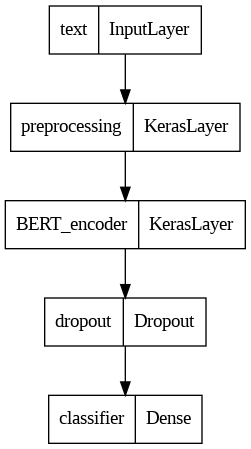

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# My data

path_1_1 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/test/neg'
path_1_2 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos'
path_2_1 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/train/neg'
path_2_2 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/train/pos'

i = 0

for r in train.query('propaganda == 1')['text']:
  i = i + 1
  with open(f'{path_2_1}/{i}.txt', 'w') as file:
    file.write(r)

for r in train.query('propaganda == 0')['text']:
  i = i + 1
  with open(f'{path_2_2}/{i}.txt', 'w') as file:
    file.write(r)

for r in test.query('propaganda == 1')['text']:
  i = i + 1
  with open(f'{path_1_1}/{i}.txt', 'w') as file:
    file.write(r)

for r in test.query('propaganda == 0')['text']:
  i = i + 1
  with open(f'{path_1_2}/{i}.txt', 'w') as file:
    file.write(r)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28621.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28622.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28623.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28624.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28625.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28626.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28627.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28628.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28629.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28630.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28631.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28632.txt
/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/28633.txt


In [ ]:
with open('/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos/32704.txt') as f:
  print(f.read())

mar the pristine view from one of his two scottish golf courses he was referring to senator kelly ayotte a republican who was unseated by new hampshire s governor maggie hassan a democrat ms ayotte had turned against mr trump late in the campaign saying that she misspoke when she called him a role model the heck he s referring to is representative joe heck a republican who was defeated


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 27490 files belonging to 2 classes.
Using 21992 files for training.
Found 27490 files belonging to 2 classes.
Using 5498 files for validation.
Found 67240 files belonging to 2 classes.


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print(np.array(label_batch))

In [ ]:
# dataset

# AUTOTUNE = tf.data.AUTOTUNE
# batch_size = 32
# seed = 42

# test_tf = tf.data.Dataset.from_tensor_slices(test_new.to_dict(orient = 'list'))
# train_tf = tf.data.Dataset.from_tensor_slices(train_new.to_dict(orient = 'list'))
# valid_tf = tf.data.Dataset.from_tensor_slices(valid_new.to_dict(orient = 'list'))

# test_tf.element_spec['text'] = tf.TensorSpec((), tf.string, 'sentences')
# train_tf.element_spec['text'] = tf.TensorSpec((), tf.string, 'sentences')
# #train_tf.element_spec['propaganda'] = tf.TensorSpec((), tf.int32, 'sentences')
# valid_tf.element_spec['text'] = tf.TensorSpec((), tf.string, 'sentences')

# test_tf = test_tf.cache().prefetch(buffer_size=AUTOTUNE)
# train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
# valid_tf = valid_tf.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

NameError: ignored

In [ ]:
print(train_tf)

In [ ]:
# Load
# load_results = open(folder_path + 'file_name.pickle', 'rb')
# name = pickle.load(load_results)

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = train_ds, validation_data = val_ds, epochs = epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
688/688 [==============================] - 745s 1s/step - loss: 0.5050 - binary_accuracy: 0.7413 - val_loss: 0.3780 - val_binary_accuracy: 0.8352
Epoch 2/5
688/688 [==============================] - 743s 1s/step - loss: 0.3449 - binary_accuracy: 0.8437 - val_loss: 0.3613 - val_binary_accuracy: 0.8572
Epoch 3/5
688/688 [==============================] - 752s 1s/step - loss: 0.2524 - binary_accuracy: 0.8920 - val_loss: 0.4044 - val_binary_accuracy: 0.8519
Epoch 4/5
688/688 [==============================] - 758s 1s/step - loss: 0.1846 - binary_accuracy: 0.9250 - val_loss: 0.4056 - val_binary_accuracy: 0.8663
Epoch 5/5
688/688 [==============================] - 747s 1s/step - loss: 0.1404 - binary_accuracy: 0.9434 - val_loss: 0.4406 - val_binary_accuracy: 0.8612


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2102/2102 [==============================] - 642s 306ms/step - loss: 0.5597 - binary_accuracy: 0.8372
Loss: 0.5597345232963562
Accuracy: 0.8372397422790527


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


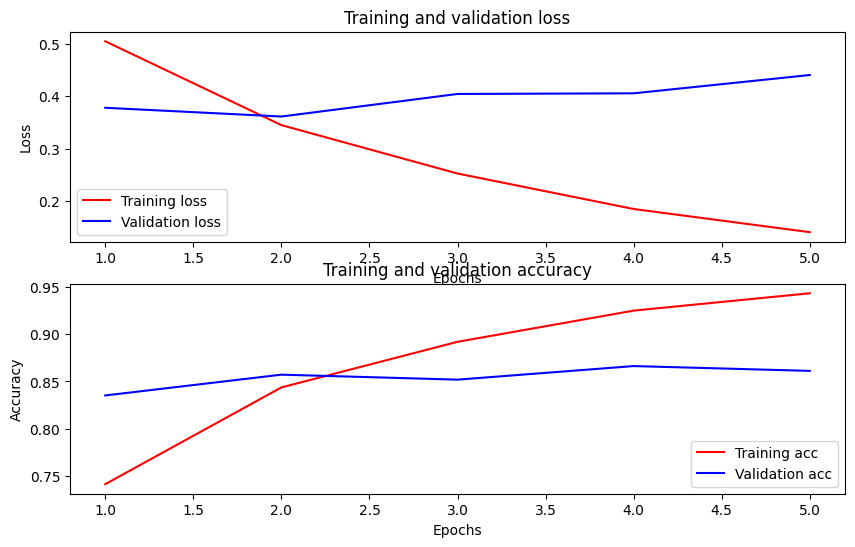

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

------------------------------

In [ ]:
!pip show tensorflow

In [ ]:
!pip install --upgrade tensorflow==<1.14.0>

In [ ]:
pip install tensorflow==2.8.0rc0

In [ ]:
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text

bert_preprocess = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

--------------

In [ ]:
!pip install -q opencv-python
!pip install -q -U "tensorflow-text==2.11.*"
!pip install -q tf-models-official
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

In [ ]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

In [ ]:
glue

In [ ]:
info.features

In [ ]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

In [ ]:
special = tokenizer.get_special_tokens_dict()
special

In [ ]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

In [ ]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

In [ ]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [ ]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

In [ ]:
example_inputs, example_labels = next(iter(glue_train))

In [ ]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

In [ ]:
plt.pcolormesh(example_inputs['input_mask'])

------------------

In [ ]:
!pip install datasets transformers==4.18.0 sentencepiece
!pip install tensorflow==2.12

In [ ]:
from datasets import *
from transformers import *
from tokenizers import *
import os
import json

In [ ]:
special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
]

In [ ]:
tokenizer = BertWordPieceTokenizer()
files = ['/content/drive/My Drive/Colab Work/Saved Results/test.txt', '/content/drive/My Drive/Colab Work/Saved Results/train.txt']
tokenizer.train(files = files, vocab_size = vocabulary_size)
tokenizer.enable_truncation(max_length = max_length)

----------

In [ ]:
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

tokenizer = Tokenizer(models.WordPiece(unl_token="[UNK]"))

In [ ]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

In [ ]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

In [ ]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

In [ ]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

In [ ]:
tokenizer.train_from_iterator(train, trainer=trainer)
#tokenizer.train_from_iterator(test, trainer=trainer)

In [ ]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")

In [ ]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", cls_token_id),
        ("[SEP]", sep_token_id),
    ],
)

In [ ]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

In [ ]:
from transformers import BertTokenizerFast

new_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

-------------

In [ ]:
model_path = "pretrained-bert"
# make the directory if not already there
if not os.path.isdir(model_path):
  os.mkdir(model_path)
# save the tokenizer
tokenizer.save_model(model_path)
# dumping some of the tokenizer config to config file,
# including special tokens, whether to lower case and the maximum sequence length
with open(os.path.join(model_path, "config.json"), "w") as f:
  tokenizer_cfg = {
      "do_lower_case": True,
      "unk_token": "[UNK]",
      "sep_token": "[SEP]",
      "pad_token": "[PAD]",
      "cls_token": "[CLS]",
      "mask_token": "[MASK]",
      "model_max_length": max_length,
      "max_len": max_length,
  }
  json.dump(tokenizer_cfg, f)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [ ]:
truncate_longer_samples = False

In [ ]:
def encode_with_truncation(text):
  """Mapping function to tokenize the sentences passed with truncation"""
  return tokenizer(text, truncation=True, padding="max_length",
                   max_length=max_length, return_special_tokens_mask=True)

def encode_without_truncation(text):
  """Mapping function to tokenize the sentences passed without truncation"""
  return tokenizer(text, return_special_tokens_mask=True)

# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# tokenizing the train dataset
for line in train:
  train.applymap(encode)
# tokenizing the testing dataset
test_dataset = test.applymap(encode)
if truncate_longer_samples:
  # remove other columns and set input_ids and attention_mask as PyTorch tensors
  train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
  test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
  # remove other columns, and remain them as Python lists
  test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
  train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

In [ ]:
from itertools import chain
# Main data processing function that will concatenate all texts from our dataset and generate chunks of
# max_seq_length.
# grabbed from: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

# Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a
# remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value
# might be slower to preprocess.
#
# To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
if not truncate_longer_samples:
  train_dataset = train_dataset.map(group_texts, batched=True,
                                    desc=f"Grouping texts in chunks of {max_length}")
  test_dataset = test_dataset.map(group_texts, batched=True,
                                  desc=f"Grouping texts in chunks of {max_length}")
  # convert them from lists to torch tensors
  train_dataset.set_format("torch")
  test_dataset.set_format("torch")

In [ ]:
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)

In [ ]:
# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.2
)

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=10,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=10, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=64,  # evaluation batch size
    logging_steps=1000,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3,           # whether you don't have much space so you let only 3 model weights saved in the disk
)

In [ ]:
# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
# train the model
trainer.train()

In [ ]:
# load the model checkpoint
model = BertForMaskedLM.from_pretrained(os.path.join(model_path, "checkpoint-10000"))
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [ ]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

In [ ]:
# perform predictions
examples = [
  "Today's most trending hashtags on [MASK] is Donald Trump",
  "The [MASK] was cloudy yesterday, but today it's rainy.",
]
for example in examples:
  for prediction in fill_mask(example):
    print(f"{prediction['sequence']}, confidence: {prediction['score']}")
  print("="*50)

-------------------

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification


In [ ]:
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_movie_score(movie_review):
	token = tokenizer.encode(movie_review, return_tensors = 'pt')
	result = model(token)
	return int(torch.argmax(result.logits))+1

for text in tqdm(df['text']):
  train['sentiment'] = train['text'].apply(lambda x: sentiment_movie_score(x[:512]))


In [ ]:
!pip install wandb
import wandb
wandb.init(project="BERT_Sentiment_Analysis")
wandb.run.log({"Sentiment Analysis of IMDB Movie Reviews" : wandb.Table(dataframe=df)})
wandb.run.finish()


-------------

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast



In [ ]:
train['propaganda'].value_counts(normalize = True)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [ ]:
# tokenize and encode sequences in the training set

for line in X_train:
  tokens_train = tokenizer.batch_encode_plus(
      line.tolist(),
      max_length = 25,
      pad_to_max_length=True,
      truncation=True
  )

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

Test model

In [ ]:
SAVED_MODEL_PATH  = "bert_news.h5"

In [ ]:
# create model and load previous weights
model = create_model(max_seq_len = data.max_seq_len)
model.load_weights(SAVED_MODEL_PATH)

In [ ]:
def predict_new(doc, model):
    """
    Predict new document using the trained model.

    doc: input document in format of a string
    """

    # clean the text
    doc = clean_txt(doc)
    # split the string text into list of subtexts
    doc = get_split(doc)
    # tokenize the subtexts as well as padding
    tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
    pred_tokens = map(tokenizer.tokenize, doc)
    pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
    pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
    pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
    pred_token_ids = np.array(list(pred_token_ids))

    # create model and load previous weights
    # model = create_model(max_seq_len = data.max_seq_len)
    # model.load_weights()

    # predict the subtexts and average the prediction
    predictions = model.predict(pred_token_ids)
    predictions = predictions[:,1]
    avg_pred = predictions.mean()
    if avg_pred > 0.5:
      doc_label = 'fake'
    else:
      doc_label = 'Real'

    return doc_label, avg_pred

In [ ]:
# Run an example text from original test set
fake_test = load_convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")
doc = fake_test['text'][7]
print('----------------------NEWS -----------------------')
print(doc)
doc_label, avg_pred = predict_new(doc, model)
print()
print('---------------- PREDICTION RESULTS --------------')
print('The predicted probability of news being FAKE is ', avg_pred)
print('CLASSIFICATION : The predicted label of news is ', doc_label.upper())

------------

In [ ]:
!pip install "thinc>=8.0.0" transformers torch "ml_datasets>=0.2.0" "tqdm>=4.41"

In [ ]:
from thinc.api import require_cpu
require_cpu()

In [ ]:
from thinc.api import prefer_gpu, use_pytorch_for_gpu_memory

is_gpu = prefer_gpu()
if is_gpu:
    use_pytorch_for_gpu_memory()

In [ ]:
CONFIG = """
[model]
@layers = "TransformersTagger.v1"
starter = "bert-base-multilingual-cased"

[optimizer]
@optimizers = "Adam.v1"

[optimizer.learn_rate]
@schedules = "warmup_linear.v1"
initial_rate = 0.01
warmup_steps = 3000
total_steps = 6000

[loss]
@losses = "SequenceCategoricalCrossentropy.v1"

[training]
batch_size = 512
words_per_subbatch = 343
n_epoch = 10
"""

In [ ]:
from typing import Optional, List
import numpy
from thinc.types import Ints1d, Floats2d
from dataclasses import dataclass
import torch
from transformers import BatchEncoding, TokenSpan


@dataclass
class TokensPlus:
    batch_size: int
    tok2wp: List[Ints1d]
    input_ids: torch.Tensor
    token_type_ids: torch.Tensor
    attention_mask: torch.Tensor

    def __init__(self, inputs: List[List[str]], wordpieces: BatchEncoding):
        self.input_ids = wordpieces["input_ids"]
        self.attention_mask = wordpieces["attention_mask"]
        self.token_type_ids = wordpieces["token_type_ids"]
        self.batch_size = self.input_ids.shape[0]
        self.tok2wp = []
        for i in range(self.batch_size):
            spans = [wordpieces.word_to_tokens(i, j) for j in range(len(inputs[i]))]
            self.tok2wp.append(self.get_wp_starts(spans))

    def get_wp_starts(self, spans: List[Optional[TokenSpan]]) -> Ints1d:
        """Calculate an alignment mapping each token index to its first wordpiece."""
        alignment = numpy.zeros((len(spans)), dtype="i")
        for i, span in enumerate(spans):
            if span is None:
                raise ValueError(
                    "Token did not align to any wordpieces. Was the tokenizer "
                    "run with is_split_into_words=True?"
                )
            else:
                alignment[i] = span.start
        return alignment


def test_tokens_plus(name: str="bert-base-multilingual-cased"):
    from transformers import AutoTokenizer
    inputs = [
        ["Our", "band", "is", "called", "worlthatmustbedivided", "!"],
        ["We", "rock", "!"]
    ]
    tokenizer = AutoTokenizer.from_pretrained(name)
    wordpieces = tokenizer(
        inputs,
        is_split_into_words=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        return_length=True,
        return_tensors="pt",
        padding="longest"
    )
    tplus = TokensPlus(inputs, wordpieces)
    assert len(tplus.tok2wp) == len(inputs) == len(tplus.input_ids)
    for i, align in enumerate(tplus.tok2wp):
        assert len(align) == len(inputs[i])
        for j in align:
            assert j >= 0 and j < tplus.input_ids.shape[1]

test_tokens_plus()

In [ ]:
import thinc
from thinc.api import Model
from transformers import AutoTokenizer

@thinc.registry.layers("transformers_tokenizer.v1")
def TransformersTokenizer(name: str) -> Model[List[List[str]], TokensPlus]:
    def forward(model, inputs: List[List[str]], is_train: bool):
        tokenizer = model.attrs["tokenizer"]
        wordpieces = tokenizer(
            inputs,
            is_split_into_words=True,
            add_special_tokens=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_length=True,
            return_tensors="pt",
            padding="longest"
        )
        return TokensPlus(inputs, wordpieces), lambda d_tokens: []

    return Model("tokenizer", forward, attrs={"tokenizer": AutoTokenizer.from_pretrained(name)})

In [ ]:
@thinc.registry.layers("transformers_model.v1")
def Transformer(name) -> Model[TokensPlus, List[Floats2d]]:
    return PyTorchWrapper(
        AutoModel.from_pretrained(name),
        convert_inputs=convert_transformer_inputs,
        convert_outputs=convert_transformer_outputs,
    )


In [ ]:
from typing import List, Tuple, Callable
from thinc.api import ArgsKwargs, torch2xp, xp2torch
from thinc.types import Floats2d

def convert_transformer_inputs(model, tokens: TokensPlus, is_train):
    kwargs = {
        "input_ids": tokens.input_ids,
        "attention_mask": tokens.attention_mask,
        "token_type_ids": tokens.token_type_ids,
    }
    return ArgsKwargs(args=(), kwargs=kwargs), lambda dX: []


def convert_transformer_outputs(
    model: Model,
    inputs_outputs: Tuple[TokensPlus, Tuple[torch.Tensor]],
    is_train: bool
) -> Tuple[List[Floats2d], Callable]:
    tplus, trf_outputs = inputs_outputs
    wp_vectors = torch2xp(trf_outputs[0])
    tokvecs = [wp_vectors[i, idx] for i, idx in enumerate(tplus.tok2wp)]

    def backprop(d_tokvecs: List[Floats2d]) -> ArgsKwargs:
        # Restore entries for BOS and EOS markers
        d_wp_vectors = model.ops.alloc3f(*trf_outputs[0].shape, dtype="f")
        for i, idx in enumerate(tplus.tok2wp):
            d_wp_vectors[i, idx] += d_tokvecs[i]
        return ArgsKwargs(
            args=(trf_outputs[0],),
            kwargs={"grad_tensors": xp2torch(d_wp_vectors)},
        )

    return tokvecs, backprop

In [ ]:
import thinc
from thinc.api import PyTorchWrapper
from transformers import AutoModel

@thinc.registry.layers("transformers_model.v1")
def Transformer(name: str) -> Model[TokensPlus, List[Floats2d]]:
    return PyTorchWrapper(
        AutoModel.from_pretrained(name),
        convert_inputs=convert_transformer_inputs,
        convert_outputs=convert_transformer_outputs,
    )

In [ ]:
from thinc.api import chain, with_array, Softmax

@thinc.registry.layers("TransformersTagger.v1")
def TransformersTagger(starter: str, n_tags: int = 17) -> Model[List[List[str]], List[Floats2d]]:
    return chain(
        TransformersTokenizer(starter),
        Transformer(starter),
        with_array(Softmax(n_tags)),
    )

In [ ]:
from thinc.api import Config, registry

C = registry.resolve(Config().from_str(CONFIG))

In [ ]:
model = C["model"]
optimizer = C["optimizer"]
calculate_loss = C["loss"]
cfg = C["training"]

In [ ]:
import ml_datasets

(X_train, X_valid), (y_train, y_valid) = ml_datasets.ud_ancora_pos_tags()

y_train = list(map(model.ops.asarray, y_train))  # convert to cupy if needed
y_valid = list(map(model.ops.asarray, y_valid))  # convert to cupy if needed

model.initialize(X = X_train[:5], Y = y_train[:5])

In [ ]:
def minibatch_by_words(pairs, max_words):
    pairs = list(zip(*pairs))
    pairs.sort(key=lambda xy: len(xy[0]), reverse=True)
    batch = []
    for X, Y in pairs:
        batch.append((X, Y))
        n_words = max(len(xy[0]) for xy in batch) * len(batch)
        if n_words >= max_words:
            yield batch[:-1]
            batch = [(X, Y)]
    if batch:
        yield batch

def evaluate_sequences(model, Xs: List[Floats2d], Ys: List[Floats2d], batch_size: int) -> float:
    correct = 0.0
    total = 0.0
    for X, Y in model.ops.multibatch(batch_size, Xs, Ys):
        Yh = model.predict(X)
        for yh, y in zip(Yh, Y):
            correct += (y.argmax(axis=1) == yh.argmax(axis=1)).sum()
            total += y.shape[0]
    return float(correct / total)

In [ ]:
from tqdm.notebook import tqdm
from thinc.api import fix_random_seed

fix_random_seed(42)

for epoch in range(cfg["n_epoch"]):
    batches = model.ops.multibatch(cfg["batch_size"], X_train, y_train, shuffle=True)
    for outer_batch in tqdm(batches, leave = False):
        for batch in minibatch_by_words(outer_batch, cfg["words_per_subbatch"]):
            inputs, truths = zip(*batch)
            inputs = list(inputs)
            guesses, backprop = model(inputs, is_train=True)
            backprop(calculate_loss.get_grad(guesses, truths))
        model.finish_update(optimizer)
        optimizer.step_schedules()
    score = evaluate_sequences(model, X_valid, y_valid, cfg["batch_size"])
    print(epoch, f"{score:.3f}")

#### Pre-trained Embeddings

In [ ]:
print('-'*30)

embedding_dim = 200
embeddings_index = {}

with open(f"glove.twitter.27B.{embedding_dim}d.txt") as f:
   for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:],
       dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
hits = 0
misses = 0

embedding_matrix = np.zeros((total_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

text_train_list = text_train_proc.tolist()
text_valid_list = text_valid_proc.tolist()

vocab_size = 100000
max_length = 100
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(text_train_list)

word_index = tokenizer.word_index
total_words = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(text_train_list)
valid_sequences = tokenizer.texts_to_sequences(text_valid_list)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

------------------------------------------

In [ ]:
from keras.layers import *

validation_data = (valid_padded, valid_oh)

model = Sequential([
  Embedding(total_words, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
  SpatialDropout1D(0.6),
  GRU(50, return_sequences=False),
  Dense(150, activation='relu'),
  Dropout(0.5),
  Dense(5, activation='softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(train_padded, train_oh, epochs=5, batch_size=128, validation_data=validation_data)

## Final code

In [1]:
!pip uninstall tensorflow --y
!pip install tensorflow
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)


In [14]:
from google.colab import drive
import pandas as pd
import re
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

drive.mount("/content/drive")
X_fake_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/DataSet_Misinfo_FAKE.csv')
X_true_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/DataSet_Misinfo_TRUE.csv')
X_propaganda_m = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/EXTRA_RussianPropagandaSubset.csv')

df_v = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/Politifact_data.csv')
X_fake_f = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/Fake.csv')
X_true_f = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/True.csv')

df_t = pd.read_csv('/content/drive/My Drive/Colab Work/Kaggle/twitter_dataset.csv')

X_m_fp = pd.concat([X_fake_m, X_propaganda_m], ignore_index=True)
X_m_fp['propaganda'] = 1
X_true_m['propaganda'] = 0
df_m = pd.concat([X_m_fp, X_true_m], ignore_index=True)
df_m = df_m.drop(columns=['Unnamed: 0'])
df_m = df_m.sample(frac=1).reset_index(drop=True)
df_m = df_m.dropna()

df_v = df_v.drop(columns=['Title', 'StartDate', 'Link'])
df_v = df_v.rename(columns={"Post": "text", "Status": "propaganda"})
df_v = df_v[df_v.propaganda.isin(['no-flip', 'half-flip', 'full-flop']) == False]
df_v = df_v.replace(['half-true', 'barely-true', 'false', 'pants-fire'], 1)
df_v = df_v.replace(['true', 'mostly-true'], 0)
df_v = df_v.sample(frac=1).reset_index(drop=True)

X_true_f['propaganda'] = 0
X_fake_f['propaganda'] = 1
df_f = pd.concat([X_true_f, X_fake_f], ignore_index=True)
df_f = df_f.drop(columns=['title', 'subject', 'date'])
df_f = df_f.sample(frac=1).reset_index(drop=True)

df_t = df_t.drop(columns=['Unnamed: 0', 'id', 'created_at'])
df_t = df_t.rename(columns={'is_propaganda': 'propaganda'})
df_t = df_t.replace(['True'], 1)
df_t = df_t.replace(['False'], 0)
df_t = df_t.sample(frac=1).reset_index(drop=True)

df = pd.concat([df_m, df_v, df_f, df_t], ignore_index = True)
df = df.sample(frac=1).reset_index(drop = True)

add_info = {'text': 'War Is Peace. Freedom Is Slavery. Ignorance Is Strength.', 'propaganda': 1}
df.loc[len(df)] = add_info

folder_path = '/content/drive/My Drive/Colab Work/Saved Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

df['text'] = df['text'].apply(clean_txt)
df['text'] = df['text'].apply(clean_txt)

In [16]:
vocabulary_size = 10000
embedding_dimensions = 10000
max_length = 343
max_words = 511

def chopping_text(text):

    data_b_sc_af_sw_lc_ct = [ ]
    part_text = [ ]

    if len(text.split()) // max_words > 0:
        n = len(text.split()) // max_words
    else:
        n = 1

    for w in range(n):

        if w == 0:
            part_text = text.split()[:max_length]
            data_b_sc_af_sw_lc_ct.append(" ".join(part_text))
        else:
            part_text = text.split()[w*max_words:w*max_words + max_length]
            data_b_sc_af_sw_lc_ct.append(" ".join(part_text))

    return data_b_sc_af_sw_lc_ct

df['text'] = df['text'].apply(chopping_text)

In [17]:
def augumentation(data):

    index = [ ]
    text = [ ]
    propaganda = [ ]

    for ind, row in data.iterrows():

      for i in row['text']:

        index.append(ind)
        text.append(i)
        propaganda.append(row['propaganda'])

    data_b_sc_af_sw_lc_ct_a = pd.DataFrame ({'index': index, 'text': text, 'propaganda': propaganda})

    return data_b_sc_af_sw_lc_ct_a

df = augumentation(df)

In [18]:
# train = df.iloc[:357449,:]
# test = df.iloc[357449:,:]
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [19]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [20]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [22]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [27]:
path_1_1 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/test/neg'
path_1_2 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/test/pos'
path_2_1 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/train/neg'
path_2_2 = '/content/drive/My Drive/Colab Work/Prefetched Dataset/train/pos'

i = 0

for r in train.query('propaganda == 1')['text']:
  i = i + 1
  with open(f'{path_2_1}/{i}.txt', 'w') as file:
    file.write(r)

for r in train.query('propaganda == 0')['text']:
  i = i + 1
  with open(f'{path_2_2}/{i}.txt', 'w') as file:
    file.write(r)

for r in test.query('propaganda == 1')['text']:
  i = i + 1
  with open(f'{path_1_1}/{i}.txt', 'w') as file:
    file.write(r)

for r in test.query('propaganda == 0')['text']:
  i = i + 1
  with open(f'{path_1_2}/{i}.txt', 'w') as file:
    file.write(r)

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/My Drive/Colab Work/Prefetched Dataset/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 257882 files belonging to 2 classes.
Using 206306 files for training.
Found 257882 files belonging to 2 classes.
Using 51576 files for validation.
Found 85622 files belonging to 2 classes.


In [29]:
[(train_features, label_batch)] = train_ds.take(1)

In [30]:
epochs = 1
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [31]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [33]:
import pickle
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = train_ds, validation_data = val_ds, epochs = epochs)
save_results = open(folder_path + 'BERT_df.pickle', 'wb')
pickle.dump(history, save_results)
save_results.close()

In [34]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2676/2676 [==============================] - 783s 292ms/step - loss: 0.4303 - binary_accuracy: 0.8108
Loss: 0.4303150177001953
Accuracy: 0.8108313083648682


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


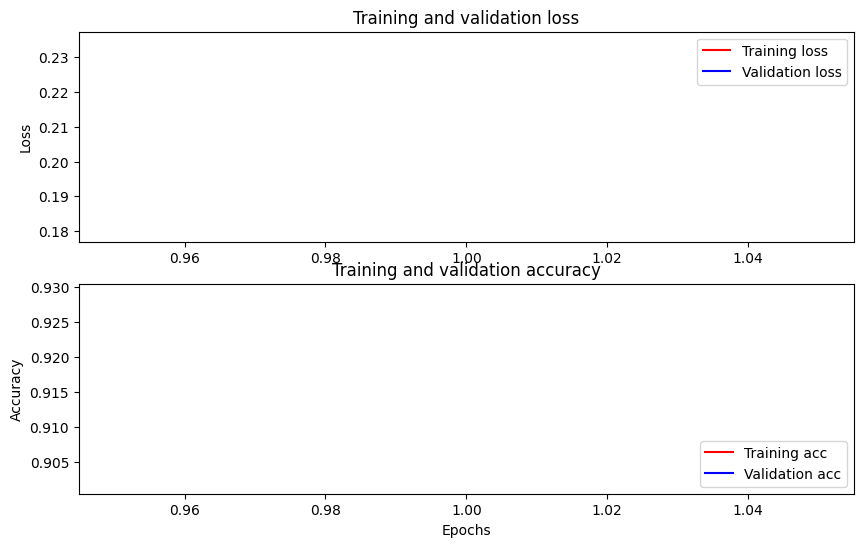

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')